# Checking CPU and GPU status

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading and analysing the dataset

## Importing the dataset

We import the dataset and converts it to a pandas dataframe. This project was developed using [Microsoft Azure Machine Learning Studio](https://azure.microsoft.com/) instead of [Google Colab](https://colab.research.google.com/) as the latter is significantly slower; 
because of this the following chunk of code might look a little bit different than usual.

In [2]:
import numpy as np
from azureml.core import Workspace, Dataset

subscription_id = 'ed1a640d-cd7a-43ba-ac37-d539b7fce5f1'
resource_group = 'DeepLearning'
workspace_name = 'Assignment'

workspace = Workspace(subscription_id, resource_group, workspace_name)

data = Dataset.get_by_name(workspace, name='fer2013')
data = data.to_pandas_dataframe()

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Plotting the labels
Here we plot a graph with the number of emoctions samples in the dataset, we notice that it is significantly unmbalanced.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
lookup = ('anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')
y = data['emotion']
sns.countplot(x=y)
plt.xticks(range(7), lookup);


## Formatting the dataset

We format the data, splitting in training, validation and test set. We create a custom ```torch.utils.data.Dataset``` and use the usual ```torch.utils.data.DataLoader```.


In [4]:
data_train = data[data.Usage =='Training'].reset_index(drop=True) 
data_val = data[data.Usage =='PrivateTest'].reset_index(drop=True) 
data_test = data[data.Usage =='PublicTest'].reset_index(drop=True) 

print(data_train.shape,data_val.shape,data_test.shape)

(28709, 3) (3589, 3) (3589, 3)


Custom Dataset.

In [5]:
class FER2013(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.loc[index]
        image, label = np.array([x.split() for x in self.data.loc[index, ['pixels']]]), row['emotion']
        image = np.asarray(image).astype(np.uint8).reshape(48, 48, 1)

        if self.transforms:
            image = self.transforms(image)

        return image, label

## Transformations
Here we define some transformations.

In [6]:
import torchvision

trfm_train = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
trfm_val_test = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])

data_train = FER2013(data_train, trfm_train)
data_val = FER2013(data_val, trfm_val_test)
data_test = FER2013(data_test, trfm_val_test)

data_train[0]

(tensor([[[-0.4510, -0.3725, -0.3569,  ..., -0.5922, -0.6627, -0.6784],
          [-0.4902, -0.5216, -0.5451,  ..., -0.5608, -0.5922, -0.6549],
          [-0.6078, -0.6627, -0.5765,  ..., -0.6157, -0.5608, -0.6314],
          ...,
          [-0.2863, -0.4902, -0.6706,  ..., -0.4353, -0.5608, -0.6627],
          [-0.3961, -0.3569, -0.3804,  ..., -0.1765, -0.4510, -0.6392],
          [-0.3961, -0.4353, -0.3412,  ..., -0.1686, -0.1451, -0.3569]]]),
 0)

In [7]:
batch_size = 128

loader_train = torch.utils.data.DataLoader(data_train, batch_size,
shuffle=True, pin_memory=True)
loader_val = torch.utils.data.DataLoader(data_val, batch_size, pin_memory=True)
loader_test = torch.utils.data.DataLoader(data_test, batch_size, pin_memory=True)

## Show batch sample
We show a sample of a batch of the training set, just to visualize the images and for being sure that after the transformations everything is fine.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


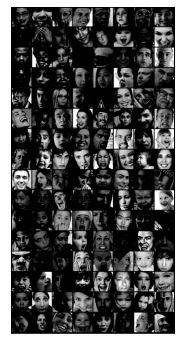

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(loader_train)

# Training and validation

## The model
Here we have the actual model. A function conv_block was created containing some operations which are repeated in the model.

In [9]:
class Model_base(torch.nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                 
        loss = torch.nn.functional.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)                    
        loss = torch.nn.functional.cross_entropy(out, labels)   
        acc = accuracy(out, labels)         
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [10]:
def conv_block(in_chnl, out_chnl, padding=1):
    layers = [
        torch.nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding, stride=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(out_chnl),
        torch.nn.MaxPool2d(2),
        torch.nn.Dropout(0.4)]
    return torch.nn.Sequential(*layers)

class Model(Model_base):
   def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_chnls, 256, kernel_size=3, padding=1) # 256x48x48
        self.block1 = conv_block(256, 512)           # 512x24x24 
        self.block2 = conv_block(512, 384)                # 384x12x12       
        self.block3 = conv_block(384, 192)       # 192x6x6 
        self.block4 = conv_block(192, 384)       # 384x3x3
    
        self.classifier = torch.nn.Sequential(torch.nn.Flatten(),
                                        torch.nn.Linear(3456, 256),
                                        torch.nn.ReLU(),
                                        torch.nn.BatchNorm1d(256),
                                        torch.nn.Dropout(0.3),
                                        torch.nn.Linear(256, num_cls))    
   def forward(self, xb):
        out = self.conv1(xb)
        out = self.block1(out)
        out = self.block2(out)       
        out = self.block3(out)
        out = self.block4(out)
        
        return self.classifier(out)

## Training and evaluation loop
The usual training and evaluation loop.

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, loader_train, loader_val, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in loader_train:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, loader_val)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Here we define some parameters and we pass to the model the dimension of input and output.

In [12]:
model = Model(1,7).to(device) 
optimizer = torch.optim.Adam
lr=0.001
num_epochs=20

history = fit(num_epochs, lr, model, loader_train, loader_val, optimizer)


Epoch [0], train_loss: 1.7551, val_loss: 1.9582, val_acc: 0.3804
Epoch [1], train_loss: 1.4654, val_loss: 1.3301, val_acc: 0.4908
Epoch [2], train_loss: 1.3034, val_loss: 1.1763, val_acc: 0.5503
Epoch [3], train_loss: 1.2024, val_loss: 1.2875, val_acc: 0.5226
Epoch [4], train_loss: 1.1577, val_loss: 1.1234, val_acc: 0.5763
Epoch [5], train_loss: 1.1082, val_loss: 1.0940, val_acc: 0.5830
Epoch [6], train_loss: 1.0821, val_loss: 1.0632, val_acc: 0.5930
Epoch [7], train_loss: 1.0752, val_loss: 1.0437, val_acc: 0.6023
Epoch [8], train_loss: 1.0381, val_loss: 1.4740, val_acc: 0.6143
Epoch [9], train_loss: 1.0203, val_loss: 1.0191, val_acc: 0.6297
Epoch [10], train_loss: 0.9958, val_loss: 1.0158, val_acc: 0.6336
Epoch [11], train_loss: 0.9704, val_loss: 1.0092, val_acc: 0.6286
Epoch [12], train_loss: 0.9445, val_loss: 0.9938, val_acc: 0.6422
Epoch [13], train_loss: 0.9591, val_loss: 1.0384, val_acc: 0.6422
Epoch [14], train_loss: 0.9242, val_loss: 0.9656, val_acc: 0.6505
Epoch [15], train_lo

## Plot of the results

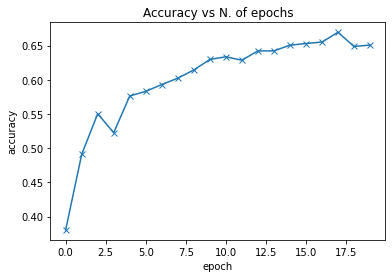

In [13]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs N. of epochs');

plot_accuracies(history)

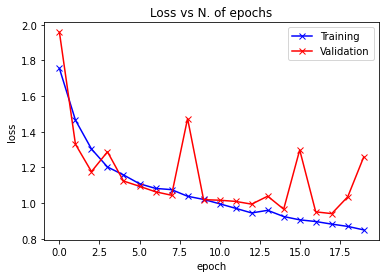

In [14]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs N. of epochs');

plot_losses(history)

# Testing and saving the model

Here we evaluate the performance on the testing set.

In [15]:
evaluate(model, loader_test)

{'val_loss': 1.1838505268096924, 'val_acc': 0.6262931227684021}

Here we manually compare the image and the emotion predicted by the network. We randomly picked the value 100 but it should be changed to check other images.

In [16]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = data_test[100] 
predict_image(img,model)
label

3

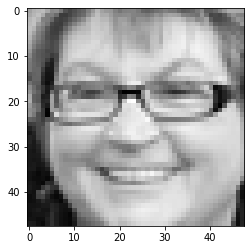

In [17]:
plt.imshow(img.squeeze(), cmap='gray')

Saving the model.

In [18]:
torch.save(model.state_dict(), './model.pt')